In [1]:
import sys
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')
import pandas as pd
import xarray as xr
from project_analysis.ephys.population_utils import *

In [2]:
from skimage.transform import resize
from scipy.signal import correlate2d

In [3]:
df1 = pd.read_pickle('/home/niell_lab/data/freely_moving_ephys/batch_files/093021/pooled_ephys_population_update_100121.pickle')


In [3]:
sessions = list(df1['session'].unique())
types = []
for session_name in sessions:
    session = df1[df1['session']==session_name]
    type_dict = session.groupby('movement_psth_type')['movement_psth_type'].count().to_dict()
    if len(type_dict) < 6:
        for key in ['late positive','biphasic','negative','unresponsive','late positive and compensatory responsive','early positive']:
            if key not in type_dict:
                type_dict[key] = 0
    types.append(type_dict)

[Text(0, 0, '012521_EE8P6LT_control_Rig2'),
 Text(0, 0, '012821_EE8P6LT_control_Rig2'),
 Text(0, 0, '021621_EE11P1LT_control_Rig2'),
 Text(0, 0, '030921_EE11P13LTRN_control_Rig2'),
 Text(0, 0, '062221_G6H31P2RT_control_Rig2'),
 Text(0, 0, '062921_G6HCK1ALTRN_control_Rig2'),
 Text(0, 0, '070621_J553LT_control_Rig2'),
 Text(0, 0, '070921_J553RT_control_Rig2'),
 Text(0, 0, '072321_J563NC_control_Rig2'),
 Text(0, 0, '072321_J563LT_control_Rig2'),
 Text(0, 0, '072721_J564LT_control_Rig2'),
 Text(0, 0, '081221_J557RT_control_Rig2'),
 Text(0, 0, '081821_J561RT_control_Rig2'),
 Text(0, 0, '090821_HGeM1LT_control_Rig2'),
 Text(0, 0, '090921_HGeM1LT_control_Rig2')]

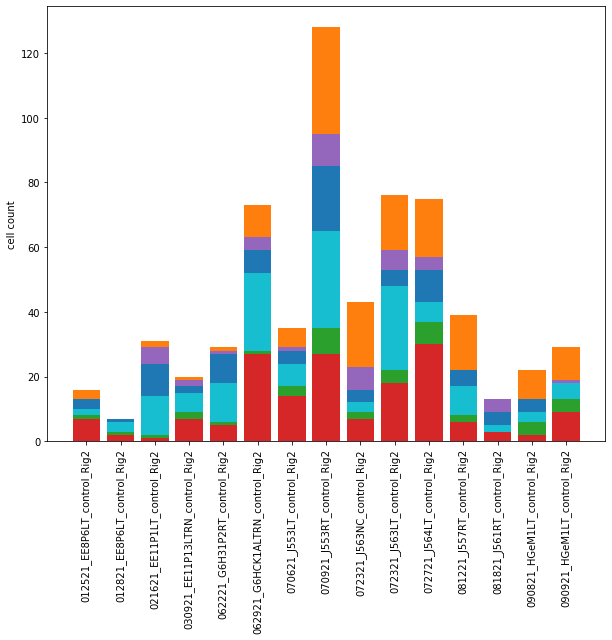

In [4]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
for s in range(len(types)):
    unresponsive = types[s]['unresponsive']; negative = types[s]['negative']
    early = types[s]['early positive']; late_pos = types[s]['late positive']; late_pos_comp = types[s]['late positive and compensatory responsive']
    biphasic = types[s]['biphasic']
    
    plt.bar(s, unresponsive, bottom=0, color='tab:red')
    plt.bar(s, negative, bottom=unresponsive, color='tab:green')
    plt.bar(s, late_pos_comp, bottom=unresponsive+negative, color='tab:cyan')
    plt.bar(s, late_pos, bottom=unresponsive+negative+late_pos_comp, color='tab:blue')
    plt.bar(s, early, bottom=unresponsive+negative+late_pos_comp+late_pos, color='tab:purple')
    plt.bar(s, biphasic, bottom=unresponsive+negative+late_pos_comp+late_pos+early, color='tab:orange')
plt.ylabel('cell count')
ax.set_xticks(range(len(sessions)))
ax.set_xticklabels(sessions, rotation=90)

[Text(0, 0, '012521_EE8P6LT_control_Rig2'),
 Text(0, 0, '012821_EE8P6LT_control_Rig2'),
 Text(0, 0, '021621_EE11P1LT_control_Rig2'),
 Text(0, 0, '030921_EE11P13LTRN_control_Rig2'),
 Text(0, 0, '062221_G6H31P2RT_control_Rig2'),
 Text(0, 0, '062921_G6HCK1ALTRN_control_Rig2'),
 Text(0, 0, '070621_J553LT_control_Rig2'),
 Text(0, 0, '070921_J553RT_control_Rig2'),
 Text(0, 0, '072321_J563NC_control_Rig2'),
 Text(0, 0, '072321_J563LT_control_Rig2'),
 Text(0, 0, '072721_J564LT_control_Rig2'),
 Text(0, 0, '081221_J557RT_control_Rig2'),
 Text(0, 0, '081821_J561RT_control_Rig2'),
 Text(0, 0, '090821_HGeM1LT_control_Rig2'),
 Text(0, 0, '090921_HGeM1LT_control_Rig2')]

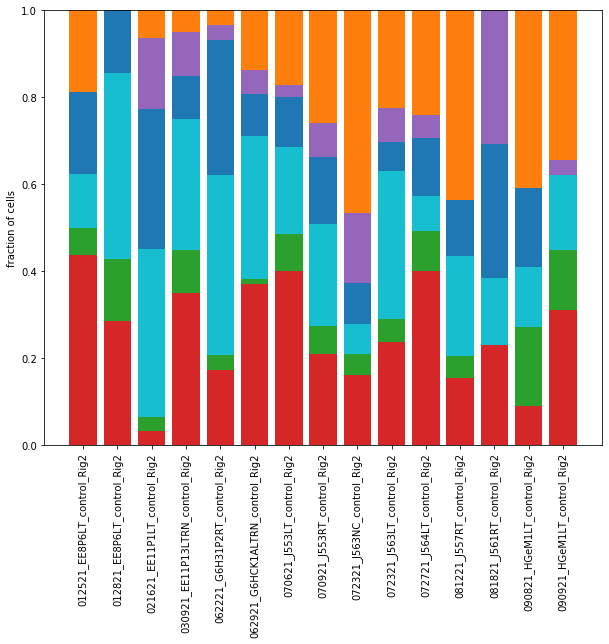

In [5]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
for s in range(len(types)):
    unresponsive = types[s]['unresponsive']/sum(types[s].values()); negative = types[s]['negative']/sum(types[s].values())
    early = types[s]['early positive']/sum(types[s].values()); late_pos = types[s]['late positive']/sum(types[s].values()); late_pos_comp = types[s]['late positive and compensatory responsive']/sum(types[s].values())
    biphasic = types[s]['biphasic']/sum(types[s].values())
    
    plt.bar(s, unresponsive, bottom=0, color='tab:red')
    plt.bar(s, negative, bottom=unresponsive, color='tab:green')
    plt.bar(s, late_pos_comp, bottom=unresponsive+negative, color='tab:cyan')
    plt.bar(s, late_pos, bottom=unresponsive+negative+late_pos_comp, color='tab:blue')
    plt.bar(s, early, bottom=unresponsive+negative+late_pos_comp+late_pos, color='tab:purple')
    plt.bar(s, biphasic, bottom=unresponsive+negative+late_pos_comp+late_pos+early, color='tab:orange')
    
plt.ylabel('fraction of cells')
ax.set_xticks(range(len(sessions)))
ax.set_xticklabels(sessions, rotation=90)

Text(0.5, 1.0, 'exc')

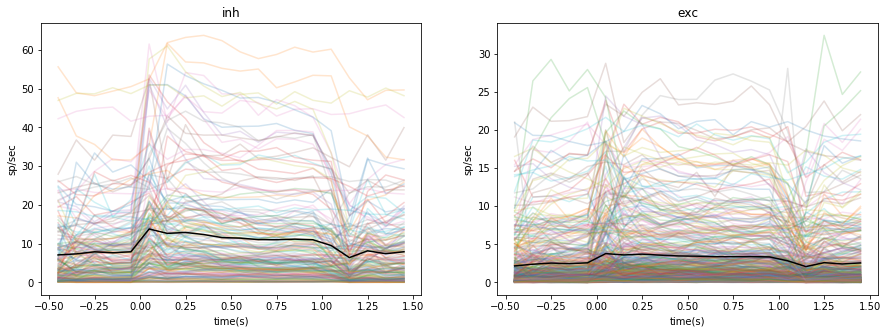

In [15]:
# mean gratings psth for each cluster split into inh/exc cells
# is median spike rate relly unchanged?

inh_grat_psth = flatten_series(df1[df1['waveform_km_label']==0]['hf3_gratings_grating_psth'])
exc_grat_psth = flatten_series(df1[df1['waveform_km_label']==1]['hf3_gratings_grating_psth'])

lower = -0.5; upper = 1.5; dt = 0.1
bins = np.arange(lower,upper+dt,dt)
gratpsth_x = bins[0:-1]+dt/2

plt.subplots(1,2,figsize=(15,5))
plt.subplot(1,2,1)
for i in range(np.size(inh_grat_psth, 0)):
    plt.plot(gratpsth_x, inh_grat_psth[i,:], alpha=0.2)  
plt.plot(gratpsth_x, np.mean(inh_grat_psth,0), 'k')
plt.xlabel('time(s)'); plt.ylabel('sp/sec')
plt.title('inh')
plt.subplot(1,2,2)
for i in range(np.size(exc_grat_psth, 0)):
    plt.plot(gratpsth_x, exc_grat_psth[i,:], alpha=0.2)  
plt.plot(gratpsth_x, np.mean(exc_grat_psth,0), 'k')
plt.xlabel('time(s)'); plt.ylabel('sp/sec')
plt.title('exc')

Text(0, 0.5, 'fraction of all SbC cells in cluster')

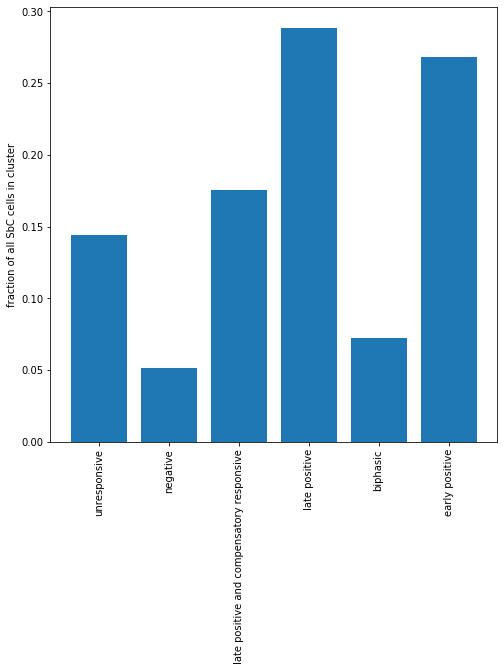

In [17]:
# which clsuter to SbC cells fall into?
sbc_inds = np.where(df1['hf1_wn_crf_modind'].dropna()<0)[0]
clusts = df1['movement_psth_type'].iloc[list(sbc_inds)]
sbc_count_in_clusts = df1.iloc[list(sbc_inds)].groupby('movement_psth_type')['movement_psth_type'].count().to_dict()
fig, ax = plt.subplots(1,1,figsize=(8,8))
tempcolors = ['tab:orange','tab:purple','tab:blue', 'tab:cyan', 'tab:green', 'tab:red']
plt.bar(clusts.unique(), list(sbc_count_in_clusts.values())/(np.ones(6)*sum(sbc_count_in_clusts.values())))
ax.set_xticklabels(clusts.unique(), rotation=90)
plt.ylabel('fraction of all SbC cells in cluster')

In [58]:
trange = np.arange(-1,1.1,0.025)
sacc_x = 0.5*(trange[0:-1] + trange[1:])

In [64]:
pref_deflection = df1['norm_deflection_at_pref_direction'].apply(np.abs).apply(np.nanmax)
opp_deflection = df1['norm_deflection_at_opp_direction'].apply(np.abs).apply(np.nanmax)

df1['sacc_direction_selectivity'] = (pref_deflection - opp_deflection) / (pref_deflection + opp_deflection)


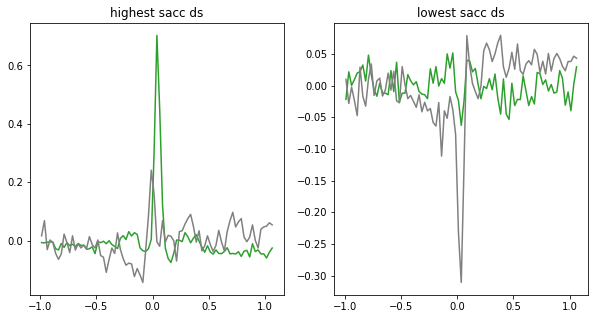

In [65]:
high_sacc_ds = df1['sacc_direction_selectivity'].argmax(); low_sacc_ds = df1['sacc_direction_selectivity'].argmin()
plt.subplots(1,2,figsize=(10,5))
plt.subplot(1,2,1)
plt.title('highest sacc ds')
plt.plot(sacc_x, df1.loc[high_sacc_ds,'norm_deflection_at_pref_direction'], color='tab:green')
plt.plot(sacc_x, df1.loc[high_sacc_ds,'norm_deflection_at_opp_direction'], color='gray')
plt.subplot(1,2,2)
plt.title('lowest sacc ds')
plt.plot(sacc_x, df1.loc[low_sacc_ds,'norm_deflection_at_pref_direction'], color='tab:green')
plt.plot(sacc_x, df1.loc[low_sacc_ds,'norm_deflection_at_opp_direction'], color='gray')

In [67]:
clust_dict = dict(zip(sorted(df1['movement_psth_type'].unique()), range(6)))
df1['clust_color'] = 'unresponsive'
for ind, row in df1.iterrows():
    df1.at[ind, 'clust_color'] = ['tab:orange','tab:purple','tab:blue', 'tab:cyan', 'tab:green', 'tab:red'][clust_dict[row['movement_psth_type']]]
    

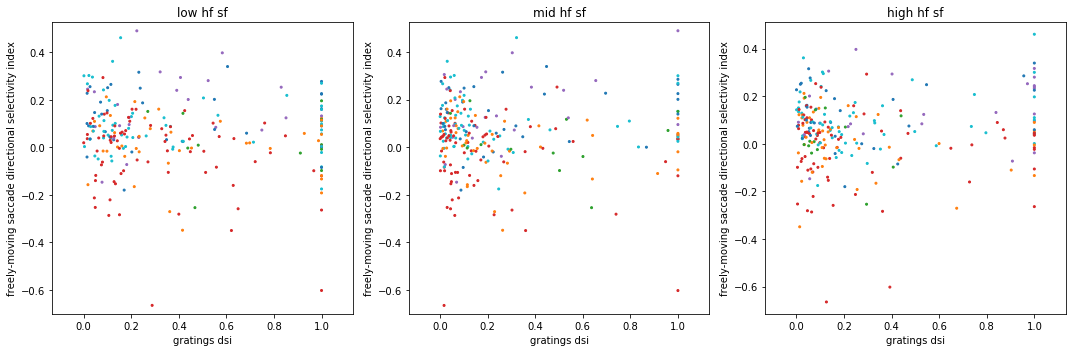

In [68]:
grat_resp = df1[df1['responsive_to_gratings']]
plt.subplots(1,3,figsize=(15,5))
for count, sf in enumerate([col for col in df1.columns.values if 'grat' in col and 'dsi' in col]):
    plt.subplot(1,3,count+1)
    plt.axis('equal')
    hf = grat_resp[sf]
    fm = grat_resp['sacc_direction_selectivity']
    tempcolors = grat_resp['clust_color']
    plt.scatter(hf, fm, color=tempcolors, s=4)
    plt.xlabel('gratings dsi')
    plt.ylabel('freely-moving saccade directional selectivity index')
    plt.title(['low hf sf','mid hf sf','high hf sf'][count])
plt.tight_layout()

In [101]:
ori_tuning = df1['hf3_gratings_ori_tuning'].iloc[0]
drift_spont = df1['hf3_gratings_drift_spont'].iloc[0]

In [102]:
np.shape(ori_tuning)

(8, 3, 2)

In [ ]:
np.sum(np.mean(ori_tuning,2)

In [ ]:
# difference in deg between direction pref for gratings and direction pref for sacc
grat_resp = df1[df1['responsive_to_gratings']]
plt.subplots(1,3,figsize=(15,5))
for count, sf in enumerate():
    plt.subplot(1,3,count+1)
    plt.axis('equal')
    hf = grat_resp[sf]
    fm = grat_resp['sacc_direction_selectivity']
    tempcolors = grat_resp['clust_color']
    plt.scatter(hf, fm, color=tempcolors, s=4)
    plt.xlabel('gratings dsi')
    plt.ylabel('freely-moving saccade directional selectivity index')
    plt.title(['low hf sf','mid hf sf','high hf sf'][count])
plt.tight_layout()

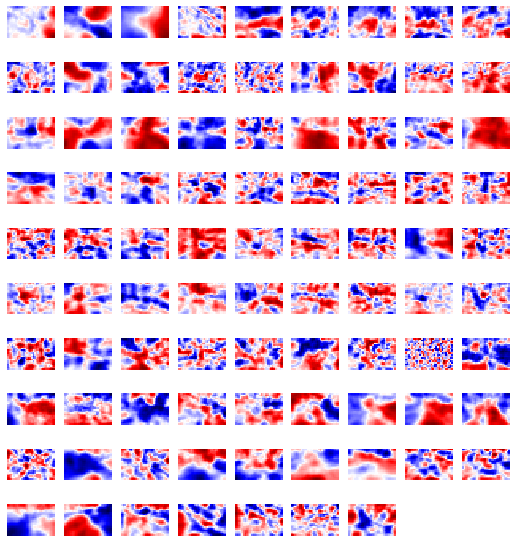

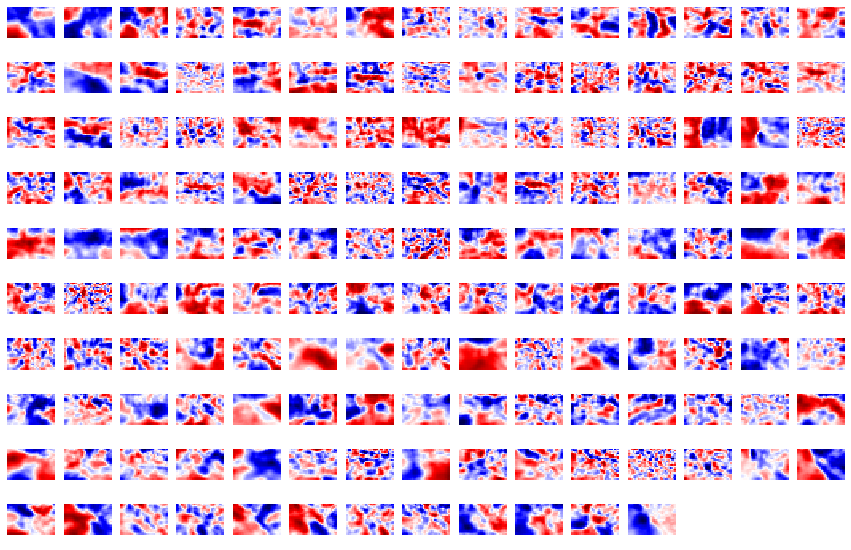

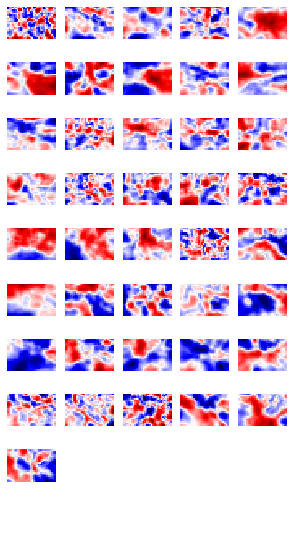

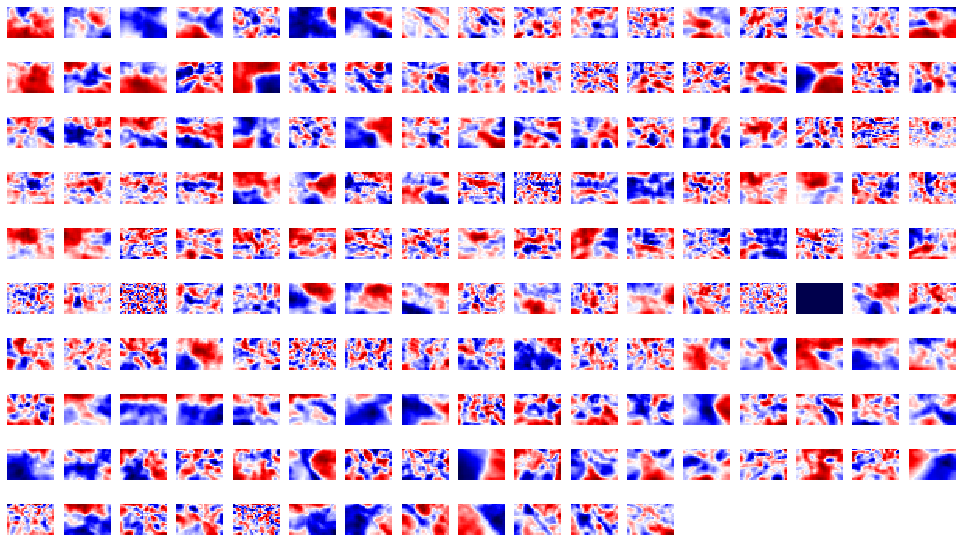

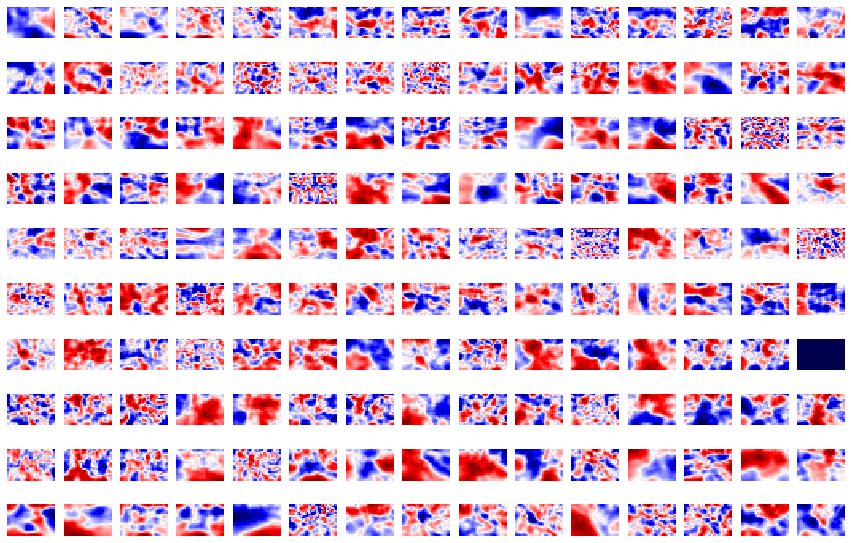

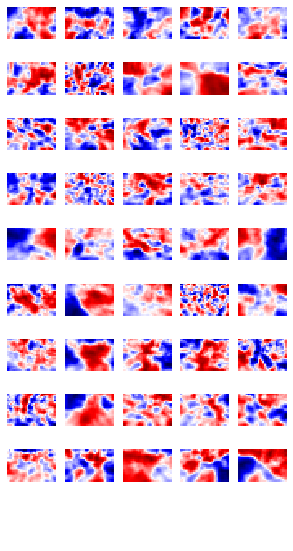

In [78]:
# montage of fm RFs
for count, clust_name in enumerate(df1['movement_psth_type'].unique()):
    cluster = df1[df1['movement_psth_type']==clust_name]
    n_units = len(cluster)
    plt.subplots(10,int(np.ceil(n_units/10)),figsize=(int(np.ceil(n_units/10)),10))
    count = 1
    for ind, row in cluster.iterrows():
        rf = row['fm1_glm_receptive_field'][np.argmax(row['fm1_glm_cc'])]
        crange = np.max(np.abs(rf))
        plt.subplot(10,int(np.ceil(n_units/10)),count)
        plt.imshow(rf, vmin=-crange, vmax=crange, cmap='seismic')
        plt.axis('off')
        count += 1
    for r in range(count, 1+(10*int(np.ceil(n_units/10)))):
        plt.subplot(10,int(np.ceil(n_units/10)),r)
        plt.axis('off')
    plt.show()

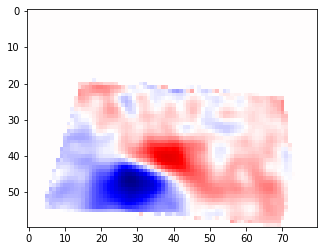

In [4]:
this_unit = 22
this_clust = df1[df1['movement_psth_type']=='early positive']
rf = np.reshape(this_clust['hf1_wn_spike_triggered_average'].iloc[this_unit],tuple(this_clust['hf1_wn_sta_shape'].iloc[this_unit]))
crange = np.max(np.abs(rf))*1.2
if crange<0.25:
    crange=0.25
plt.imshow(rf, vmin=-crange, vmax=crange, cmap='seismic')

In [242]:
def gabor(sigma, theta, Lambda, psi, gamma, xoffset, yoffset):
    """
    Parameters
    sigma: stddev of envelope
    theta: orientation
    Lambda: wavelength of sinusoidal factor
    psi: phase offset
    gamma: spatial aspect ratio
    """
    imgsize = (80,60)
    center = (yoffset*imgsize[0],xoffset*imgsize[1])
    
#     theta = np.clip(theta, -np.pi, np.pi)
#     sigma = np.clip(sigma, 3, np.min(imgsize)/2)
    
    sigma_x = sigma
    sigma_y = float(sigma) / gamma
    
    # Bounding box
    ymax, xmax = (imgsize[0],imgsize[1])
    xmax, ymax = (xmax - 1)/2, (ymax - 1)/2
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax+1), np.arange(xmin, xmax+1))

    # Rotation
    x_theta = (x-center[0]) * np.cos(theta) + (y-center[1]) * np.sin(theta)
    y_theta = -(x-center[0]) * np.sin(theta) + (y-center[1]) * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    
    return gb

In [243]:
init_theta = np.random.rand(1)
init_sigma = np.random.rand(1)+3
init_Lambda = np.random.rand(1)+9.5
init_psi = np.random.rand(1)*np.pi/2
init_gamma = np.random.rand(1)+1
init_xoffset = np.array(0.)
init_yoffset = np.array(0.)

In [244]:
from sklearn.metrics import mean_squared_error as MSE

In [258]:
from tqdm import tqdm
from scipy.optimize import fmin_bfgs, minimize

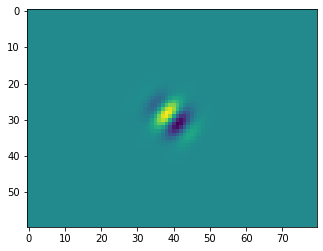

In [254]:
plt.imshow(gabor(init_sigma, init_theta, init_Lambda, init_psi, init_gamma, init_xoffset, init_yoffset))

In [246]:
init_gabor = gabor(init_sigma, init_theta, init_Lambda, init_psi, init_gamma, init_xoffset, init_yoffset)
MSE(rf, init_gabor)

0.00919294884806405

In [247]:
def apply_gabor(params, rf):
    sigma, theta, Lambda, psi, gamma, xoffset, yoffset = params
    filt = gabor(sigma, theta, Lambda, psi, gamma, xoffset, yoffset)
    return MSE(filt.flatten(), rf.flatten())

In [248]:
np.shape(rf)

(60, 80)

In [ ]:
res = minimize(apply_gabor, x0=[init_sigma, init_theta, init_Lambda, init_psi, init_gamma, init_xoffset, init_yoffset], args=rf, method='Nelder-Mead', tol=10**-20, options={'maxiter':10**6})


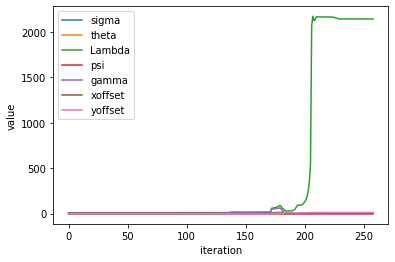

In [239]:
allvecs = np.array(res[-1])
param_labels = ['sigma', 'theta', 'Lambda', 'psi', 'gamma','xoffset','yoffset']
for count in range(np.size(allvecs,1)):
    plt.plot(allvecs[:,count], label=param_labels[count])
plt.ylabel('value'); plt.xlabel('iteration')
plt.legend()

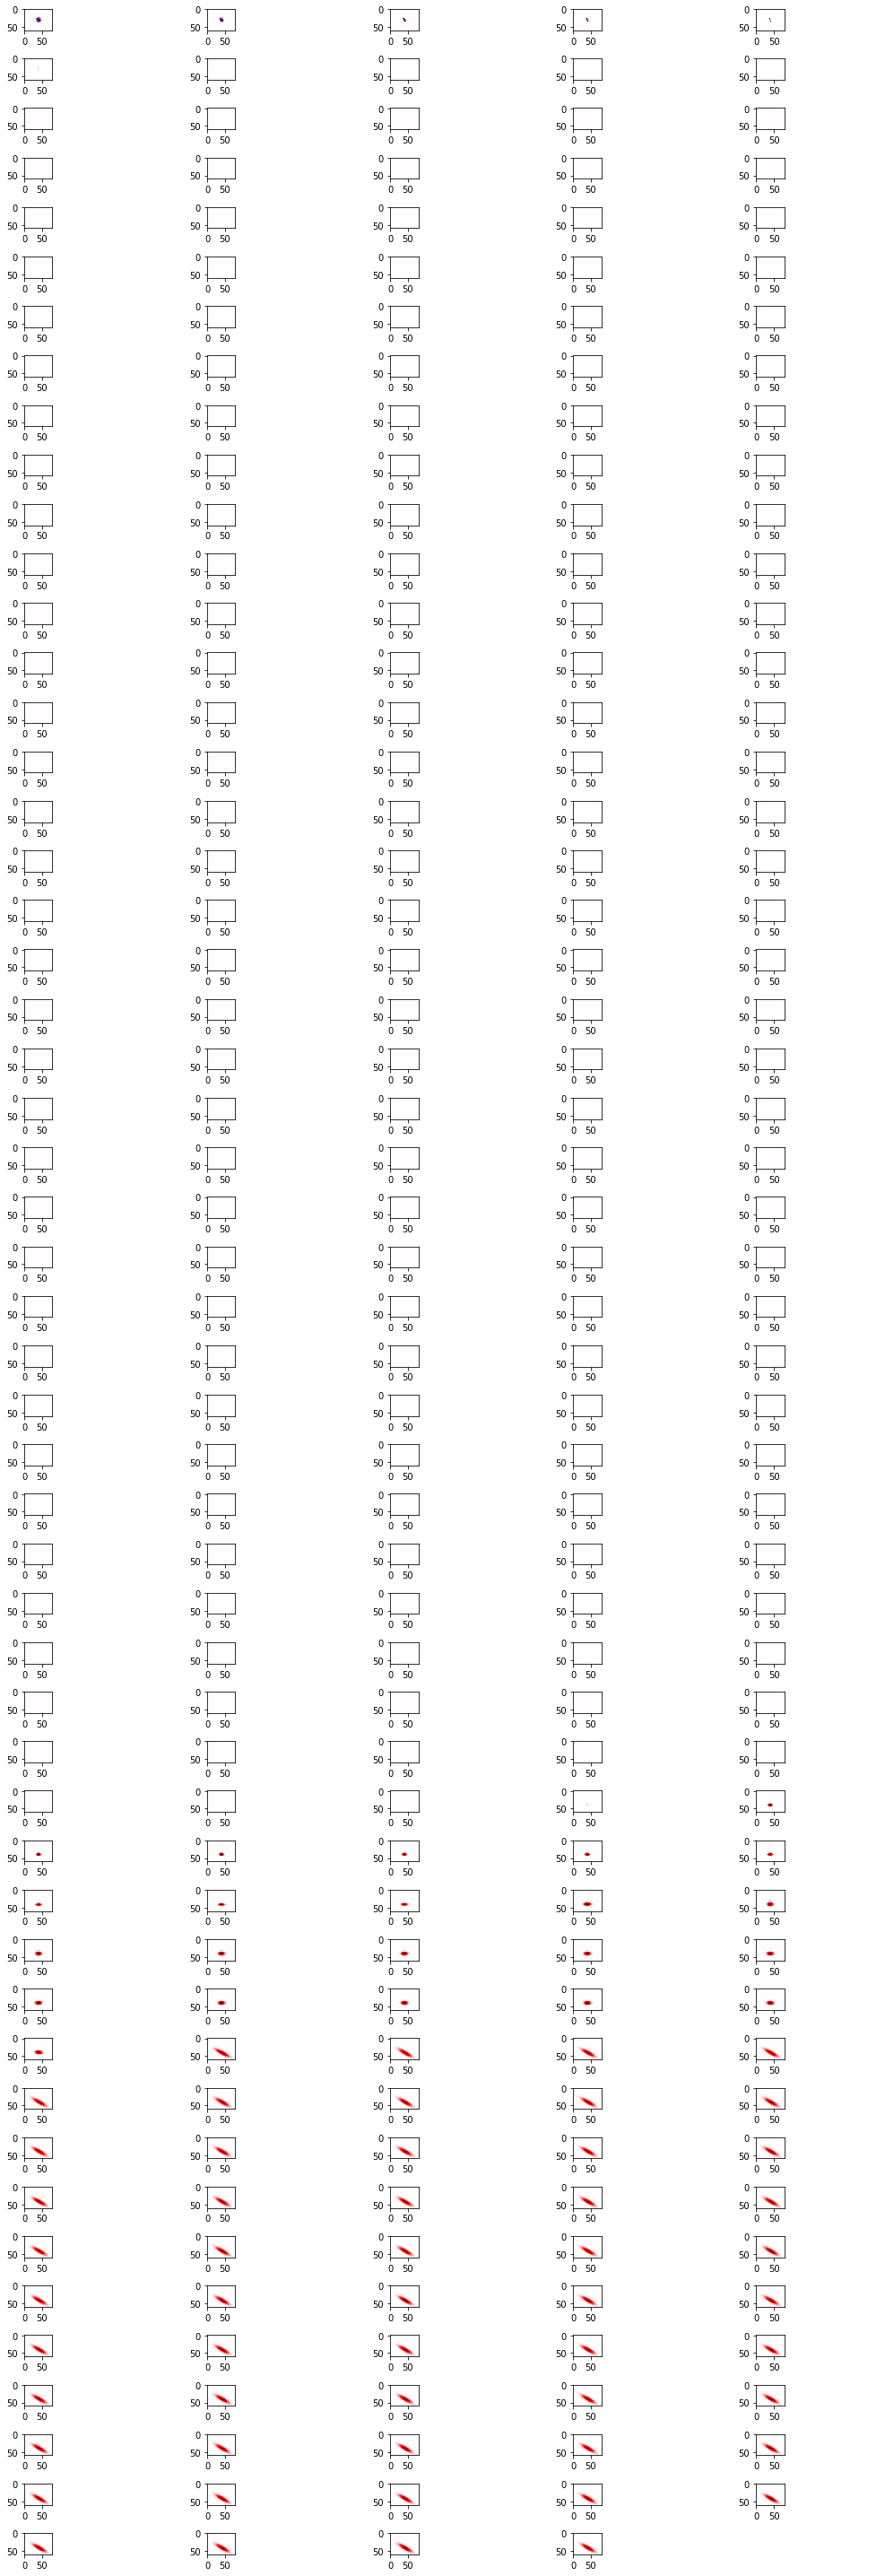

In [237]:
num_steps = np.size(allvecs,0)
plt.subplots(int(np.ceil(num_steps/5)),5,figsize=(15,40))
for step in range(num_steps):
    sigma, theta, Lambda, psi, gamma, x, y = allvecs[step]
    fit = gabor(sigma, theta, Lambda, psi, gamma, x, y)
    fitrange = np.max(np.abs(fit_filt))
    plt.subplot(int(np.ceil(num_steps/5)),5,step+1)
    plt.imshow(fit, vmin=-fitrange, vmax=fitrange, cmap='seismic')
for rem in range(step+2,1+(int(np.ceil(num_steps/5))*5)):
    plt.subplot(int(np.ceil(num_steps/5)),5,rem)
    plt.axis('off')
plt.tight_layout()

In [265]:
sigma, theta, Lambda, psi, gamma, x, y = res['x']

In [266]:
fit_filt = gabor(sigma, theta, Lambda, psi, gamma, x, y)

(array([3045.,  651.,  236.,  166.,  138.,  116.,  112.,  109.,  119.,
         108.]),
 array([-0.0116281 ,  0.00106083,  0.01374977,  0.02643871,  0.03912765,
         0.05181659,  0.06450552,  0.07719446,  0.0898834 ,  0.10257234,
         0.11526128]),
 <a list of 10 Patch objects>)

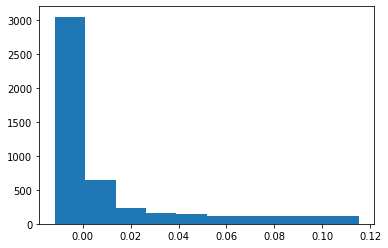

In [267]:
plt.hist(fit_filt.flatten())

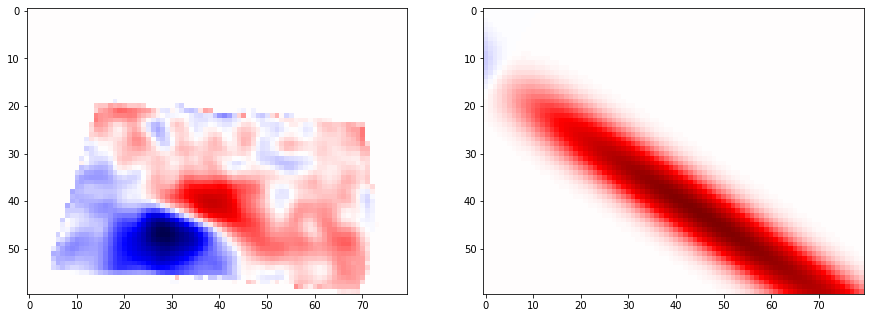

In [268]:
plt.subplots(1,2,figsize=(15,10))
plt.subplot(1,2,1)
rfrange = np.max(np.abs(rf))
plt.imshow(rf, vmin=-rfrange, vmax=rfrange, cmap='seismic')
plt.subplot(1,2,2)
fitrange = np.max(np.abs(fit_filt))
plt.imshow(fit_filt, vmin=-fitrange, vmax=fitrange, cmap='seismic')

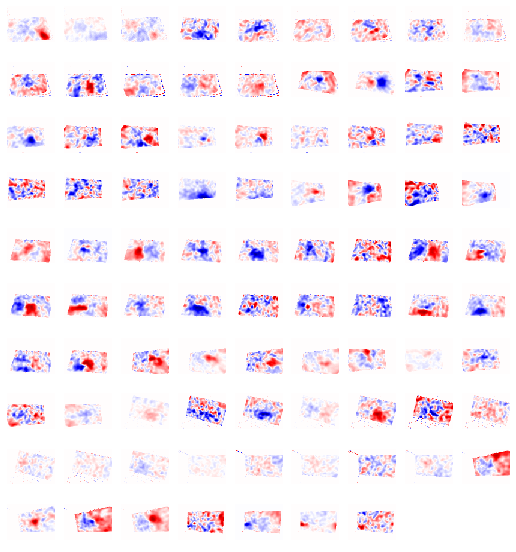

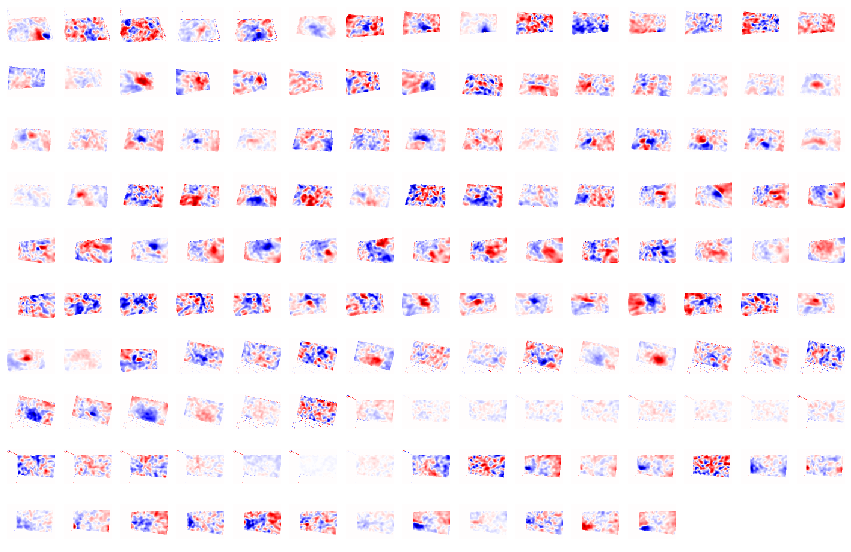

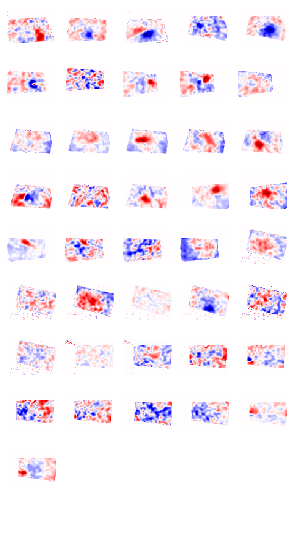

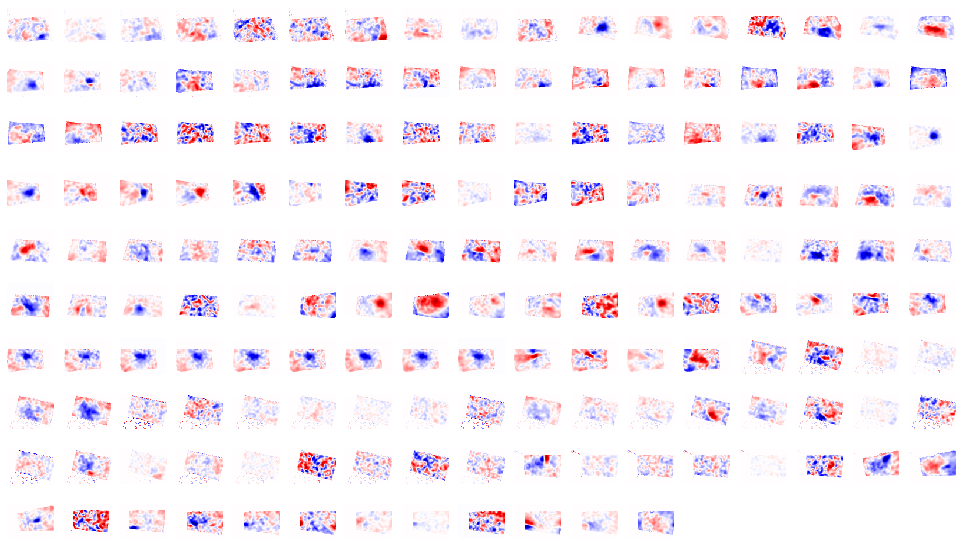

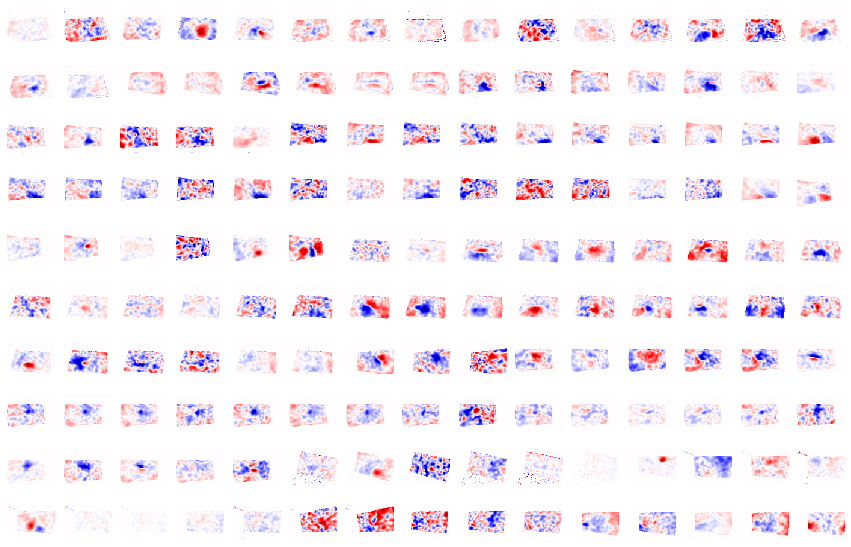

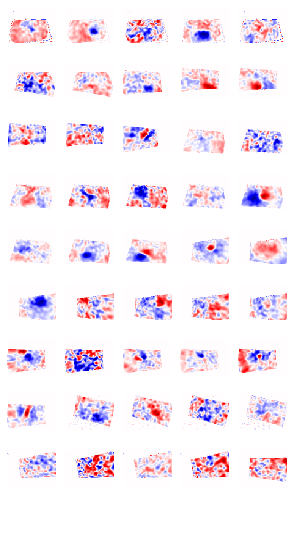

In [80]:
# montage of hf RFs
for count, clust_name in enumerate(df1['movement_psth_type'].unique()):
    cluster = df1[df1['movement_psth_type']==clust_name]
    n_units = len(cluster)
    plt.subplots(10,int(np.ceil(n_units/10)),figsize=(int(np.ceil(n_units/10)),10))
    count = 1
    for ind, row in cluster.iterrows():
        rf = row['hf1_wn_spike_triggered_average']
        crange = np.max(np.abs(rf))*1.2
        if crange<0.25:
            crange=0.25
        plt.subplot(10,int(np.ceil(n_units/10)),count)
        plt.imshow(np.reshape(rf,tuple(row['hf1_wn_sta_shape'])), vmin=-crange, vmax=crange, cmap='seismic')
        plt.axis('off')
        count += 1
    for r in range(count, 1+(10*int(np.ceil(n_units/10)))):
        plt.subplot(10,int(np.ceil(n_units/10)),r)
        plt.axis('off')
    plt.show()

In [9]:
np.shape(np.reshape(row['hf1_wn_spike_triggered_average'],tuple(row['hf1_wn_sta_shape'])))

(60, 80)

In [14]:
np.shape(resize(row['fm1_glm_receptive_field'][np.argmax(row['fm1_glm_cc'])], (60,80)))

(60, 80)

In [20]:
for count, clust_name in enumerate(df1['movement_psth_type'].unique()):
    cluster = df1[df1['movement_psth_type']==clust_name]
    n_units = len(cluster)
    count = 1
    for ind, row in cluster.iterrows():
        hf = np.reshape(row['hf1_wn_spike_triggered_average'],tuple(row['hf1_wn_sta_shape']))
        fm = resize(row['fm1_glm_receptive_field'][np.argmax(row['fm1_glm_cc'])], np.shape(hf))
        if row['responsive_to_contrast']:
            df1.at[ind, 'rf_corr_coeff'] = np.correlate(hf.flatten(), fm.flatten())

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   2.,   2.,   1.,   4.,   3.,   2.,   6.,  14.,  13.,  23.,
         48., 120.,  38.,  15.,  10.,   8.,   8.,   3.,   4.,   4.,   1.,
          1.,   2.,   1.,   4.,   0.,   2.,   0.,   2.,   0.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.06392893, -0.06121375, -0.05849858, -0.0557834 , -0.05306822,
        -0.05035305, -0.04763787, -0.04492269, -0.04220752, -0.03949234,
        -0.03677717, -0.03406199, -0.03134681, -0.02863164, -0.02591646,
        -0.02320128, -0.02048611, -0.01777093, -0.01505575, -0.01234058,
        -0.0096254 , -0.00691022, -0.00419505, -0.00147987,  0.00123531,
         0.00395048,  0.00666566,  0.00938083,  0.01209601,  0.01481119,
         0.01752636,  0.02024154,  0.02295672,  0.02567189,  0.02838707,
         0.03110225,  0.03381742,  0.0365326 ,  0.03924778,  0.04196295,
         0.04467813,  0.04739331,  0.05010848,  0.05282366,  0.05553884,
 

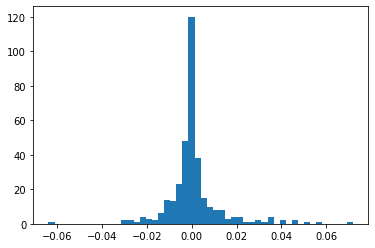

In [23]:
plt.hist(df1['rf_corr_coeff'], bins=50)